In [73]:
import numpy as np
import pandas as pd

# Load data
df = pd.read_csv('technical.csv', index_col=0, parse_dates=True)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Create sma_20, vol_20
df['sma_20'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(20, min_periods=20).mean())
df['vol_ma20'] = df.groupby('ticker')['volume'].transform(lambda x: x.rolling(20).mean())

# Creating return of each day & volatility
df['return_cc'] = df.groupby('ticker')['close'].pct_change()
df['volatility'] = df.groupby('ticker')['return_cc'].rolling(20).std().reset_index(level=0, drop=True)

# Shift volatility to avoid lookahead bias
df['volatility'] = df.groupby('ticker')['volatility'].shift(1)
print(df)

# Split into train, test
train_df = df[df.index < '2025-01-01']
test_df = df[df.index >= '2025-01-01']

# Benchmark to be drawn on chart
benchmark = pd.read_csv('benchmark.csv', index_col=0, parse_dates=True)
benchmark['date'] = pd.to_datetime(benchmark['timestamp'])
benchmark = benchmark.set_index('date')
benchmark_for_train =  benchmark[benchmark.index < '2025-01-01']
benchmark_for_test = benchmark[benchmark.index >= '2025-01-01']

/var/folders/dg/g887cwtn1l36b11xqd4xth200000gn/T/ipykernel_84075/1241421307.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('technical.csv', index_col=0, parse_dates=True)


           ticker          open          high           low         close  \
date                                                                        
2023-01-03    A32  24472.273392  24472.273392  24472.273392  24472.273392   
2023-01-04    A32  24472.273392  24472.273392  24472.273392  24472.273392   
2023-01-05    A32  24472.273392  24472.273392  24472.273392  24472.273392   
2023-01-06    A32  24472.273392  24472.273392  24472.273392  24472.273392   
2023-01-09    A32  23499.865178  23499.865178  23499.865178  23499.865178   
...           ...           ...           ...           ...           ...   
2025-08-26    YBC  11600.000000  11600.000000  11600.000000  11600.000000   
2025-08-27    YBC  11600.000000  11600.000000  11600.000000  11600.000000   
2025-08-28    YBC  11500.000000  11600.000000  10500.000000  11418.000000   
2025-08-29    YBC  10600.000000  10800.000000  10600.000000  10763.000000   
2025-09-03    YBC  11600.000000  11600.000000  11000.000000  11091.000000   

/var/folders/dg/g887cwtn1l36b11xqd4xth200000gn/T/ipykernel_84075/1241421307.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  benchmark = pd.read_csv('benchmark.csv', index_col=0, parse_dates=True)


# Filtering which stocks to be long/short based on the comparison of sma_20, sma50, rsi indicator and volum signal

In [74]:
# Filtering signals to be of stock each day
def filtering_signals(df: pd.DataFrame):
    df['buy_signal'] = (df['sma_20'] > df['sma_50']) & (df['rsi'] < 30) & (df['volume'] > df['vol_ma20'])
    df['sell_signal'] = (df['sma_20'] < df['sma_50']) & (df['rsi'] > 70) & (df['volume'] > df['vol_ma20'])
    return df

In [75]:
# Generating position, we can only long in VN market, so sell_signal we just set the position to be 0
def create_position(df: pd.DataFrame):
    df['position'] = 0 
    df.loc[df['buy_signal'], 'position'] = 1
    df.loc[df['sell_signal'], 'position'] = 0
    # Shift position to avoid lookahead bias
    df['position'] = df.groupby('ticker')['position'].shift(1).fillna(0).astype(int)
    return df

# Allocate weights based on votality

In [76]:
def votality_backward_weight_strategy(data: pd.DataFrame):
    # chỉ lấy những dòng có position != 0
    subset = data[data['position'] != 0].copy()
    if subset.empty:
        return pd.Series(0.0, index=data.index)

    # tính 1/vol
    subset['inv_volatility'] = 1.0 / subset['volatility'].replace(0, np.nan)

    # weight chuẩn hóa để tổng = 1
    subset['weight'] = subset['inv_volatility'] / subset['inv_volatility'].sum()

    # gán weight ngược về toàn bộ DataFrame
    weights = pd.Series(0.0, index=data.index)
    weights.loc[subset.index] = subset['weight']
    return weights

In [77]:
def back_test(df):
    for date in df['date'].unique():
        mask = df['date'] == date
        df.loc[mask, 'weight'] = votality_backward_weight_strategy(df[mask])

    df['strategy_return'] = df['position'] * df['return_cc'] * df['weight']
    # portfolio return mỗi ngày
    # Equity curve (PnL tích lũy)
    daily_ret = df.groupby('date')['strategy_return'].sum().fillna(0.0).reset_index()

    # Đánh số thứ tự ngày (convert về numpy array hoặc Series)
    daily_ret['day_num'] = np.arange(1, len(daily_ret) + 1)

    # Giữ lại ngày lẻ (1, 3, 5, ...) và bỏ hết ngày chẵn
    daily_ret = daily_ret[daily_ret['day_num'] % 2 == 1]

    # Đưa về Series
    daily_ret = daily_ret.set_index('date')['strategy_return']

    # equity curve
    equity = (1 + daily_ret).cumprod()

    # metrics
    cum_return = equity.iloc[-1] - 1
    rf_annual = 0.03783   
    rf_daily = (1 + rf_annual)**(1/252) - 1
    sharpe = ((daily_ret.mean() - rf_daily) / daily_ret.std()) * np.sqrt(252)
    max_dd = (equity / equity.cummax() - 1).min()

    # Annualized Return 
    # Create a full schedule of business days in the range, fill missing days with 0 (for T+2 settlement)
    full_days = pd.date_range(start=daily_ret.index.min(), end=daily_ret.index.max(), freq='B')  # business days
    daily_ret_full = daily_ret.reindex(full_days, fill_value=0.0)
    equity_full = (1 + daily_ret_full).cumprod()
    
    # Annualized return calculation based on 252 trading days / year
    ann_return = equity_full.iloc[-1]**(252 / max(len(daily_ret_full), 1)) - 1


    # trades, win-rate
    daily_trades = df[df['weight'] != 0].groupby('date').size()
    total_trades = int(daily_trades.sum())
    avg_trades_per_day = float(daily_trades.mean()) if len(daily_trades) else 0.0
    daily_win_rate = (daily_ret > 0).mean()

    # === In kết quả ===
    print(f"Cumulative Return: {cum_return:.2%}")
    print(f"Annualized Return: {ann_return:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_dd:.2%}")
    print(f"Total Trades: {total_trades}")
    print(f"Average Trades per Day: {avg_trades_per_day:.2f}")
    print(f"Daily Win Rate: {daily_win_rate:.2%}")


In [78]:
import matplotlib.pyplot as plt

def PnL_chart(df, benchmark):
    # Equity curve (PnL tích lũy)
    daily_ret = df.groupby('date')['strategy_return'].sum().fillna(0.0).reset_index()

    # Đánh số thứ tự ngày (convert về numpy array hoặc Series)
    daily_ret['day_num'] = np.arange(1, len(daily_ret) + 1)

    # Giữ lại ngày lẻ (1, 3, 5, ...) và bỏ hết ngày chẵn
    daily_ret = daily_ret[daily_ret['day_num'] % 2 == 1]

    # Đưa về Series
    daily_ret = daily_ret.set_index('date')['strategy_return']
    
    full_days = pd.date_range(start=daily_ret.index.min(), end=daily_ret.index.max(), freq='B')  # business days
    daily_ret_full = daily_ret.reindex(full_days, fill_value=0.0)
    equity_full = (1 + daily_ret_full).cumprod()

    plt.figure(figsize=(12,6))
    plt.plot(equity_full.index, equity_full.values, label="Strategy Equity Curve vs Benchmark (Normalized)", color='blue')
    for bm in benchmark["ticker"].unique():
        bm_data = benchmark[benchmark["ticker"] == bm].copy()
        bm_data = bm_data.sort_index()

        # chuẩn hoá close
        bm_data["norm_close"] = bm_data["close"] / bm_data["close"].iloc[0]

        plt.plot(bm_data.index, bm_data["norm_close"], label=f"Benchmark {bm}", linestyle="--")
    # original line
    plt.axhline(1.0, color='black', linestyle='--', linewidth=1)

    plt.title("Equity Curve vs Benchmarks (Normalized to 1.0)")
    plt.xlabel("Date")
    plt.ylabel("Normalized Portfolio Value (Start = 1.0)")
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [79]:
train_df

,ticker,open,high,low,close,volume,buy_volume,standard_deviation,foreign_buy,foreign_sell,...,sma_200,bb_hband,bb_lband,macd,atr,atr_pct,sma_20,vol_ma20,return_cc,volatility
date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,A32,24472.273392,24472.273392,24472.273392,24472.273392,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,A32,24472.273392,24472.273392,24472.273392,24472.273392,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2023-01-05,A32,24472.273392,24472.273392,24472.273392,24472.273392,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2023-01-06,A32,24472.273392,24472.273392,24472.273392,24472.273392,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2023-01-09,A32,23499.865178,23499.865178,23499.865178,23499.865178,1600.0,0.0,1600.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.039735,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,YBC,8800.000000,8800.000000,8800.000000,8800.000000,0.0,0.0,0.0,0.0,0.0,...,53.935269,9070.000000,6550.000000,231.939742,87.461843,0.009939,8010.0,10.0,0.000000,0.047720
2024-12-26,YBC,8000.000000,8000.000000,8000.000000,8000.000000,100.0,100.0,0.0,0.0,0.0,...,52.024688,9138.587024,6521.412976,171.865099,138.357425,0.017295,8050.0,15.0,-0.090909,0.033133
2024-12-27,YBC,9000.000000,9000.000000,9000.000000,9000.000000,100.0,150.0,0.0,0.0,0.0,...,54.068722,9204.252561,6495.747439,202.611573,199.903324,0.022211,8140.0,20.0,0.125000,0.040152


In [80]:
test_df

,ticker,open,high,low,close,volume,buy_volume,standard_deviation,foreign_buy,foreign_sell,...,sma_200,bb_hband,bb_lband,macd,atr,atr_pct,sma_20,vol_ma20,return_cc,volatility
date,,,,,,,,,,,,,,,,,,,,,
2025-01-02,A32,36912.66,36912.66,36912.66,36912.6600,0.0,0.0,1.0,0.0,0.0,...,53.766078,37434.149227,32382.703270,724.337892,651.802226,0.017658,34908.426248,275.0,0.000000,0.035719
2025-01-03,A32,34400.28,34400.28,33820.50,33997.3329,600.0,0.0,600.0,0.0,0.0,...,51.982446,37351.393203,32579.138691,592.453147,826.113496,0.024299,34965.265947,305.0,-0.078979,0.035741
2025-01-06,A32,34013.76,34013.76,34013.76,34013.7600,0.0,0.0,0.0,0.0,0.0,...,51.991465,37106.945265,32552.868021,483.683464,768.278753,0.022587,34829.906643,295.0,0.000483,0.040529
2025-01-07,A32,34013.76,34013.76,34013.76,34013.7600,0.0,0.0,0.0,0.0,0.0,...,51.991465,36822.839931,32566.254747,392.952990,713.401700,0.020974,34694.547339,295.0,0.000000,0.030176
2025-01-08,A32,34013.76,34013.76,34013.76,34013.7600,0.0,0.0,1.0,0.0,0.0,...,51.991465,36489.933151,32628.442919,317.389763,662.444435,0.019476,34559.188035,285.0,0.000000,0.030176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-26,YBC,11600.00,11600.00,11600.00,11600.0000,0.0,0.0,0.0,0.0,0.0,...,51.054220,13189.017596,10154.182404,-179.960141,751.694354,0.064801,11390.000000,800.0,0.000000,0.079175
2025-08-27,YBC,11600.00,11600.00,11600.00,11600.0000,0.0,0.0,0.0,0.0,0.0,...,51.054220,13186.638706,9988.361294,-152.226270,698.001900,0.060173,11408.350000,755.0,0.000000,0.074045
2025-08-28,YBC,11500.00,11600.00,10500.00,11418.0000,2200.0,1900.0,300.0,0.0,0.0,...,50.941760,13144.348476,9980.651524,-143.281199,726.716050,0.063647,11418.750000,765.0,-0.015690,0.073956


# Implement on train set to fix the strategy

/var/folders/dg/g887cwtn1l36b11xqd4xth200000gn/T/ipykernel_84075/3071116506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['buy_signal'] = (df['sma_20'] > df['sma_50']) & (df['rsi'] < 30) & (df['volume'] > df['vol_ma20'])
/var/folders/dg/g887cwtn1l36b11xqd4xth200000gn/T/ipykernel_84075/3071116506.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sell_signal'] = (df['sma_20'] < df['sma_50']) & (df['rsi'] > 70) & (df['volume'] > df['vol_ma20'])
/var/folders/dg/g887cwtn1l36b11xqd4xth200000gn/T/ip

Cumulative Return: 97.35%
Annualized Return: 38.93%
Sharpe Ratio: 3.65
Max Drawdown: -6.72%
Total Trades: 7741
Average Trades per Day: 17.24
Daily Win Rate: 57.60%


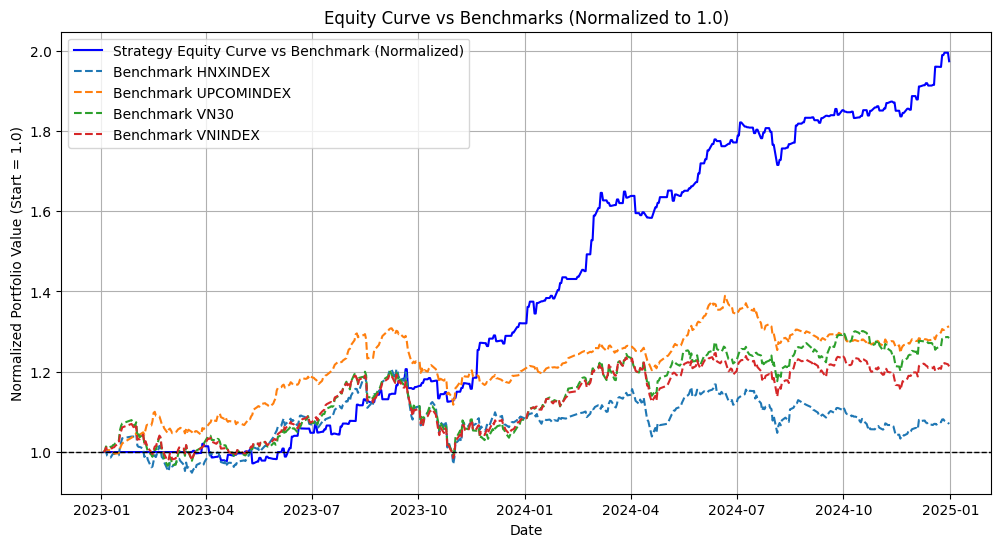

In [81]:
train_df = filtering_signals(train_df)
train_df = create_position(train_df)
# Sort ticker by each date
train_df = train_df.sort_values(by=["date", "ticker"]).reset_index(drop=False)
train_df["weight"] = 0

back_test(train_df)
PnL_chart(train_df, benchmark_for_train)

# Try on test set

/var/folders/dg/g887cwtn1l36b11xqd4xth200000gn/T/ipykernel_84075/3071116506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['buy_signal'] = (df['sma_20'] > df['sma_50']) & (df['rsi'] < 30) & (df['volume'] > df['vol_ma20'])
/var/folders/dg/g887cwtn1l36b11xqd4xth200000gn/T/ipykernel_84075/3071116506.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sell_signal'] = (df['sma_20'] < df['sma_50']) & (df['rsi'] > 70) & (df['volume'] > df['vol_ma20'])
/var/folders/dg/g887cwtn1l36b11xqd4xth200000gn/T/ip

Cumulative Return: 72.32%
Annualized Return: 121.96%
Sharpe Ratio: 5.56
Max Drawdown: -10.15%
Total Trades: 3144
Average Trades per Day: 19.29
Daily Win Rate: 74.39%


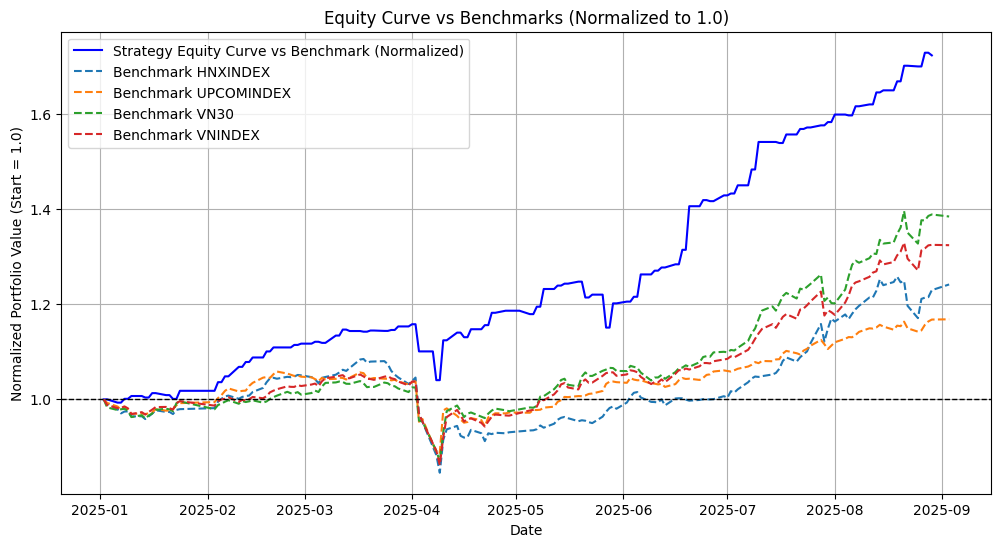

In [82]:
test_df = filtering_signals(test_df)
test_df = create_position(test_df)
# Sort ticker by each date
test_df = test_df.sort_values(by=["date", "ticker"]).reset_index(drop=False)
test_df["weight"] = 0

back_test(test_df)
PnL_chart(test_df, benchmark_for_test)